# Signal Autoencoder

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [2]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [3]:
#prong_2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
#prong_3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [4]:
rnd_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

testprior_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/ThreeProng_5000_500_500.h5")

In [16]:
dt = rnd_data.values
dt_prior = testprior_data.values

correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt_prior[:,3]>0) &(dt_prior[:,19]>0) & (dt_prior[:,1]>0) & (dt_prior[:,2]>0)
dt_prior = dt_prior[correct]

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

for i in range(13,19):
    dt_prior[:,i] = dt_prior[:,i]/dt_prior[:,3]

for i in range(29,35):
    dt_prior[:,i] = dt_prior[:,i]/(dt_prior[:,19])
#correct = (dt[:,16]>0) & (dt[:,29]>=0) & (dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#bkg_idx = np.where(idx==0)[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
correct = (dt[:,0]>=2800)
dt = dt[correct]   

correct = (dt_prior[:,0]>=2800)
dt_prior = dt_prior[correct] 

idx = dt[:,-1]

#sig_idx = np.where((dt_prior[:,3]>450) & (dt_prior[:,3]<550) & (dt_prior[:,19]>100) & (dt_prior[:,19]<200) & (dt_prior[:,0]>4200) & (dt_prior[:,0]<4800))[0]
sig_idx = np.where((dt_prior[:,3]>200)  & (dt_prior[:,19]>200) & (dt_prior[:,0]>4000) & (dt_prior[:,0]<6000))[0]

bkg_idx = np.where(idx==0)[0]
#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]

dt_sig = dt_prior[sig_idx]
dt_bkg = dt[bkg_idx]


In [17]:
#dt = prong_2.values
#correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
#dt = dt[correct]#

#for i in range(13,19):
#    dt[:,i] = dt[:,i]/dt[:,3]#

#for i in range(29,35):
#    dt[:,i] = dt[:,i]/(dt[:,19])#

##correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
##dt = dt[correct]#
#

##Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
##Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
##Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#sig_idx = np.where((idx==1) & (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150))[0]
##signal_idx = np.where((idx==1)) [0]
#dt_sig = dt[sig_idx]
#    
#sig_refine_range = (dt_sig[:,0]>3400) & (dt_sig[:,0]<3600)
#dt_sig = dt_sig[sig_refine_range]

In [18]:
dt_sig.shape

(43350, 35)

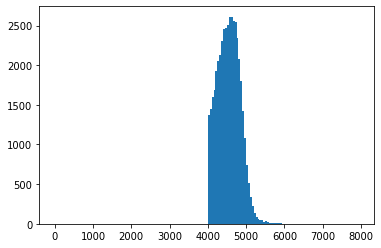

In [19]:
plt.hist(dt_sig[:,0],bins=np.arange(0,8000,50));

In [20]:
f.columns[[3,4,5,6,11,12,19,20,21,22,27,28]]

NameError: name 'f' is not defined

In [21]:
#Y = dt_sig[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
#[3,4,5,6,11,12,19,20,21,22,27,28]
Y = dt_sig[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [22]:
Y.shape

(43350, 12)

In [23]:
#if nprong == 3:
#    dt = prong_3.values
#    correct = (dt[:,3]>20) &(dt[:,19]>20)
#    dt = dt[correct]
#    for i in range(13,19):
#        dt[:,i] = dt[:,i]/dt[:,3]
    
#    for i in range(29,35):
#        dt[:,i] = dt[:,i]/(dt[:,19])
        
#    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#    dt = dt[correct]        
        
#    Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
#    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#    idx = dt[:,-1]
#    bkg_idx = np.where(idx==0)[0]
#    signal_idx = np.where((idx==1) & (dt[:,3]>400))[0]
#    #signal_idx = np.where((idx==1)) [0]
#    Y = Y[signal_idx]

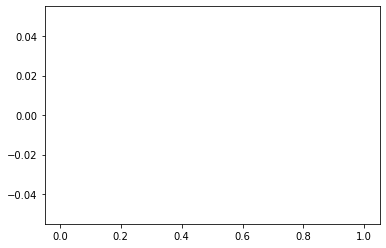

In [24]:
bins = np.linspace(0,1,100)
bins.shape
column = 3
#print(f_rnd.columns[column])
plt.hist(Y[:,0],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [25]:
Y.shape

(43350, 12)

In [26]:
sig_mean = []
sig_std = []
for i in range(12):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    sig_mean.append(mean)
    sig_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

In [27]:
sig_mean

[539.8230906175115,
 0.3093919504152834,
 0.5743852002513076,
 0.7250999951321894,
 1.3980643297136106,
 305.10717416378316,
 417.50598164552935,
 0.3423973996112709,
 0.5859205785605542,
 0.7492831266044925,
 1.6350968023267969,
 261.31617070357555]

In [28]:
sig_std

[104.54956422929888,
 0.12679648500311186,
 0.13543619747203547,
 0.11808533829680096,
 0.34103400809131684,
 100.12586819876644,
 88.97967256083908,
 0.1495063860755517,
 0.14289850921322486,
 0.11224475793826029,
 0.5509216479879365,
 82.84269505360622]

In [18]:
total_sig = torch.tensor(Y)

In [19]:
total_sig.shape

torch.Size([28514, 12])

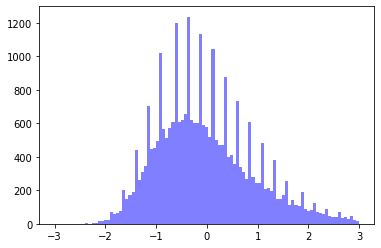

In [20]:
bins = np.linspace(-3,3,100)
bins.shape
column = 0
#print(f_rnd.columns[column])
plt.hist(Y[:,11],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [21]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

#N_FLOWS = 6 
#Z_DIM = 8

N_FLOWS = 10
Z_DIM = 8

n_steps = 0

In [22]:
sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [23]:
bs = 800
sig_train_iterator = utils.DataLoader(total_sig, batch_size=bs, shuffle=True) 
sig_test_iterator = utils.DataLoader(total_sig, batch_size=bs)

In [44]:
sigoptimizer = optim.Adam(sigmodel.parameters(), lr=1e-6)

In [45]:
beta = 1

In [46]:
def sigtrain():
    global n_steps
    train_loss = []
    sigmodel.train()

    for batch_idx, x in enumerate(sig_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = sigmodel(x)
        mseloss = nn.MSELoss(size_average=False)
        huberloss = nn.SmoothL1Loss(size_average=False)
        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta* kl_div

        sigoptimizer.zero_grad()
        loss.backward()
        sigoptimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [47]:
def sigevaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    sigmodel.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(sig_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = sigmodel(x)
            mseloss = nn.MSELoss(size_average=False)
            huberloss = nn.SmoothL1Loss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [48]:
ae_def = {
    "type":"sig",
    "trainon":"3prong",
    "features":"12features",
    "architecture":"MAF",
    "selection":"mjj4500_nojetmasscut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z8f10",
}

In [49]:
ae_def

{'type': 'sig',
 'trainon': '3prong',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjj4500_nojetmasscut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f10'}

In [50]:
#from torchsummary import summary


In [51]:
sigmodel.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

In [52]:
N_EPOCHS = 10
BEST_LOSS = 0
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    sigtrain()
    cur_loss = sigevaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(sigmodel.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
        
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -83.6661 Time: 0.526 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -83.6874 Time: 0.523 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -83.7292 Time: 0.522 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -83.6624 Time: 0.524 s
Not saving model! Last saved: 3
Epoch 5:

Evaluation Completed (valid)!	Loss: -83.7086 Time: 0.524 s
Not saving model! Last saved: 3
Epoch 6:

Evaluation Completed (valid)!	Loss: -83.7434 Time: 0.523 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -83.8253 Time: 0.523 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -83.8497 Time: 0.528 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -83.8737 Time: 0.525 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: -83.9343 Time: 0.524 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -83.8383 Time: 0.524 s
Not saving model! Last saved: 10
Epoch 12:

Evaluation Complete


Evaluation Completed (valid)!	Loss: -85.3498 Time: 0.523 s
Not saving model! Last saved: 82
Epoch 89:

Evaluation Completed (valid)!	Loss: -85.4864 Time: 0.525 s
Saving model!
Epoch 90:

Evaluation Completed (valid)!	Loss: -85.4514 Time: 0.524 s
Not saving model! Last saved: 89
Epoch 91:

Evaluation Completed (valid)!	Loss: -85.5077 Time: 0.525 s
Saving model!
Epoch 92:

Evaluation Completed (valid)!	Loss: -85.4752 Time: 0.525 s
Not saving model! Last saved: 91
Epoch 93:

Evaluation Completed (valid)!	Loss: -85.5942 Time: 0.526 s
Saving model!
Epoch 94:

Evaluation Completed (valid)!	Loss: -85.4771 Time: 0.524 s
Not saving model! Last saved: 93
Epoch 95:

Evaluation Completed (valid)!	Loss: -85.5161 Time: 0.548 s
Not saving model! Last saved: 93
Epoch 96:

Evaluation Completed (valid)!	Loss: -85.5920 Time: 0.526 s
Not saving model! Last saved: 93
Epoch 97:

Evaluation Completed (valid)!	Loss: -85.5576 Time: 0.526 s
Not saving model! Last saved: 93
Epoch 98:

Evaluation Completed (vali


Evaluation Completed (valid)!	Loss: -86.6623 Time: 0.524 s
Not saving model! Last saved: 170
Epoch 174:

Evaluation Completed (valid)!	Loss: -86.7252 Time: 0.523 s
Not saving model! Last saved: 170
Epoch 175:

Evaluation Completed (valid)!	Loss: -86.8528 Time: 0.526 s
Saving model!
Epoch 176:

Evaluation Completed (valid)!	Loss: -86.8369 Time: 0.525 s
Not saving model! Last saved: 175
Epoch 177:

Evaluation Completed (valid)!	Loss: -86.8373 Time: 0.524 s
Not saving model! Last saved: 175
Epoch 178:

Evaluation Completed (valid)!	Loss: -86.8857 Time: 0.527 s
Saving model!
Epoch 179:

Evaluation Completed (valid)!	Loss: -86.8035 Time: 0.525 s
Not saving model! Last saved: 178
Epoch 180:

Evaluation Completed (valid)!	Loss: -86.9013 Time: 0.523 s
Saving model!
Epoch 181:

Evaluation Completed (valid)!	Loss: -86.7934 Time: 0.525 s
Not saving model! Last saved: 180
Epoch 182:

Evaluation Completed (valid)!	Loss: -86.9621 Time: 0.526 s
Saving model!
Epoch 183:

Evaluation Completed (valid)!


Evaluation Completed (valid)!	Loss: -87.8642 Time: 0.525 s
Saving model!
Epoch 257:

Evaluation Completed (valid)!	Loss: -87.5036 Time: 0.525 s
Not saving model! Last saved: 256
Epoch 258:

Evaluation Completed (valid)!	Loss: -87.7133 Time: 0.525 s
Not saving model! Last saved: 256
Epoch 259:

Evaluation Completed (valid)!	Loss: -87.8693 Time: 0.524 s
Saving model!
Epoch 260:

Evaluation Completed (valid)!	Loss: -88.0239 Time: 0.534 s
Saving model!
Epoch 261:

Evaluation Completed (valid)!	Loss: -87.9230 Time: 0.529 s
Not saving model! Last saved: 260
Epoch 262:

Evaluation Completed (valid)!	Loss: -87.8039 Time: 0.525 s
Not saving model! Last saved: 260
Epoch 263:

Evaluation Completed (valid)!	Loss: -87.9409 Time: 0.525 s
Not saving model! Last saved: 260
Epoch 264:

Evaluation Completed (valid)!	Loss: -87.8019 Time: 0.526 s
Not saving model! Last saved: 260
Epoch 265:

Evaluation Completed (valid)!	Loss: -87.8857 Time: 0.525 s
Not saving model! Last saved: 260
Epoch 266:

Evaluatio


Evaluation Completed (valid)!	Loss: -89.0796 Time: 0.524 s
Saving model!
Epoch 340:

Evaluation Completed (valid)!	Loss: -88.9699 Time: 0.524 s
Not saving model! Last saved: 339
Epoch 341:

Evaluation Completed (valid)!	Loss: -89.0518 Time: 0.524 s
Not saving model! Last saved: 339
Epoch 342:

Evaluation Completed (valid)!	Loss: -89.0219 Time: 0.525 s
Not saving model! Last saved: 339
Epoch 343:

Evaluation Completed (valid)!	Loss: -89.1790 Time: 0.526 s
Saving model!
Epoch 344:

Evaluation Completed (valid)!	Loss: -89.1577 Time: 0.527 s
Not saving model! Last saved: 343
Epoch 345:

Evaluation Completed (valid)!	Loss: -89.0607 Time: 0.526 s
Not saving model! Last saved: 343
Epoch 346:

Evaluation Completed (valid)!	Loss: -89.1666 Time: 0.524 s
Not saving model! Last saved: 343
Epoch 347:

Evaluation Completed (valid)!	Loss: -89.2376 Time: 0.524 s
Saving model!
Epoch 348:

Evaluation Completed (valid)!	Loss: -89.2677 Time: 0.526 s
Saving model!
Epoch 349:

Evaluation Completed (valid)!

In [53]:
sigmodel.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

In [54]:
sigout = sigmodel(torch.tensor(Y).float().cuda())[0]
sigout = sigout.data.cpu().numpy()

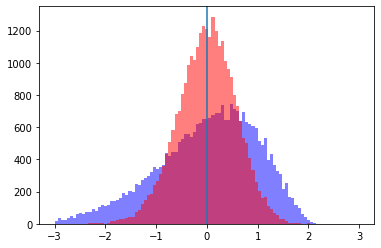

In [59]:
bins = np.linspace(-3,3,100)
bins.shape
column = 3
#print(f_rnd.columns[column]
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(Y[:,column]))

In [60]:
mjj, j1mass, j2mass = [4000, 150, 150]
f = pd.read_hdf(f"/data/t3home000/spark/QUASAR/preprocessing/delphes_output_{mjj}_{j1mass}_{j2mass}.h5")
dt = f.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
dt = dt[correct]

correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
dt = dt[correct]


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [61]:
for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

In [62]:
sigout = sigmodel(torch.tensor(Y).float().cuda())[0]
sigout = sigout.data.cpu().numpy()

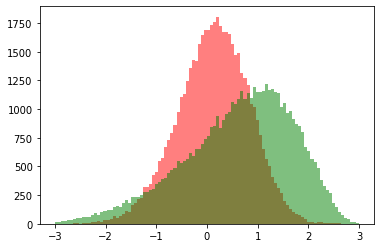

In [68]:
bins = np.linspace(-3,3,101)
bins.shape
column = 2
#print(f_rnd.columns[column]
#plt.hist(dt[:,column],bins,alpha=0.5,color='b');
plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
plt.hist(Y[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

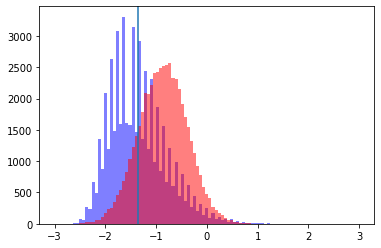

In [69]:
bins = np.linspace(-3,3,100)
bins.shape
column = 5
#print(f_rn.columns[column]
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(Y[:,column]))

In [107]:
varyj1mass_wps = ([4000, 150, 150],[4000, 300, 150],[4000, 450, 150],[4000, 500, 150],[4000, 650, 150],[4000, 700, 150],[4000, 850, 150],[4000, 900, 150])

(50885, 10)
[1.2562833  1.0150101  4.63527    3.1353111  3.1270933  2.5498352
 0.98916984 3.3142097  0.5134599  2.5206301 ]
(49079, 10)
[0.8910228  0.4618418  1.2828003  1.0181931  0.7241632  0.6351117
 1.7559447  0.3825097  0.9646135  0.95724446]
(40305, 10)
[0.5540186  1.2050751  0.3490556  1.8467045  0.75147474 0.671209
 1.4278493  1.7209883  0.83306026 1.0873885 ]
(36079, 10)
[0.4340822  7.6371846  1.1879708  0.43213457 0.3415988  0.5919516
 0.70254576 0.65806735 2.201469   0.5131256 ]
(20364, 10)
[0.5014051  1.0378898  0.6118281  0.4327641  1.1696905  0.35628533
 0.48016113 0.14187819 0.88088095 0.4277892 ]
(14582, 10)
[1.0281534  1.0762899  0.7548882  0.17842868 0.44157785 1.3323195
 0.7724545  0.33537352 0.5283326  0.60084414]
(1110, 10)
[1.4535477  0.2469969  3.3151753  0.22895774 0.8264796  2.600779
 1.0788665  0.63972807 1.0814985  1.4302014 ]
(305, 10)
[1.5050468 1.4343903 2.8387651 1.0893123 1.8100127 0.6711144 5.2034693
 1.4315116 1.7810924 1.0626707]


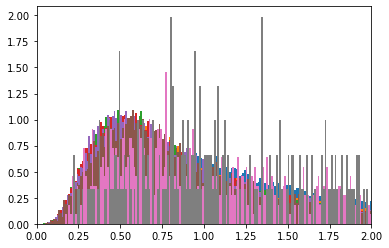

In [102]:
for mjj, j1mass, j2mass in varyj1mass_wps:
    
    f = pd.read_hdf(f"/data/t3home000/spark/QUASAR/preprocessing/delphes_output_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]

   
    Y = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

        
    
            
    print(Y.shape)
    for i in range(10):
        Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    #np.save(out_file_waic,waic)
    np.save(f'sigaetestprior4500500150_wp_{mjj}_{j1mass}_{j2mass}.npy',sigae_bbloss)

In [103]:
losslist = []
for mjj, j1mass, j2mass in varyj1mass_wps:

    a = np.load(f'sigae_wp_{mjj}_{j1mass}_{j2mass}.npy')
    losslist.append(a)
    

In [104]:
losslist[1]

array([0.2506657 , 0.45937157, 0.33064288, ..., 2.223935  , 0.28329286,
       0.67881405], dtype=float32)

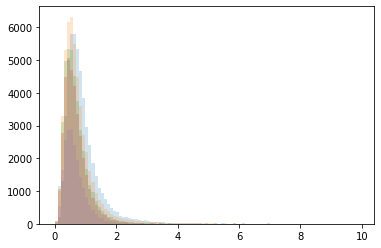

In [105]:
plt.hist(losslist[0],bins = np.arange(0,10,.1),alpha=0.2);
plt.hist(losslist[1],bins = np.arange(0,10,.1),alpha=0.2);
plt.hist(losslist[2],bins = np.arange(0,10,.1),alpha=0.2);
plt.hist(losslist[3],bins = np.arange(0,10,.1),alpha=0.2);
plt.hist(losslist[4],bins = np.arange(0,10,.1),alpha=0.2);

In [70]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5'
    
]

In [71]:
ae_def

{'type': 'sig',
 'trainon': '3prong',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjj4500_nojetmasscut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f10'}

In [72]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_4500.npy"
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy"
]

In [73]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    False,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True
    
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong',
    '4500'
    
]

(488280, 12)
[   4.7194996    2.8188367   31.315178     2.756485     8.46459
    9.533489    13.457454  2620.0085       2.9338183    4.8980436]
(505248, 12)
[ 11.387151    5.502649    6.66521    64.66336   291.8396     48.59631
   1.56672    18.174734    3.5265427   1.0036907]
(491884, 12)
[2.9693577 3.638872  1.7521389 6.586632  4.030341  1.5751424 0.9993878
 2.077943  6.8376703 3.4506798]
(499489, 12)
[ 6.3167     4.940252   0.5492481 12.029004   4.439932  15.031258
  4.5505686 10.195691   2.188146   4.007696 ]
(587907, 12)
[ 0.71913344  4.3438206   6.439454    2.0758038  10.194782   95.84833
  3.0597253   1.4067264  11.093575    8.291598  ]
(31923, 12)
[ 5.6426625  3.7302885  7.7646484  4.9270196  4.9736047  3.5290728
  4.423126   7.62922   10.038872   3.2536607]
(37441, 12)
[3.1578026 6.480542  5.0173473 6.905368  8.612096  5.4395714 7.584311
 6.36209   6.369811  5.0555463]
(26448, 12)
[2.5932555 2.7761445 5.172421  3.2248294 2.08993   3.0205383 3.8928516
 4.5390253 3.4748507 2.920

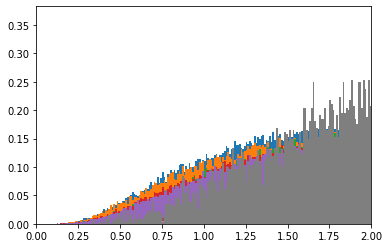

In [74]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    #correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
    #dt = dt[correct]
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])


    #correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    #dt = dt[correct]
    #correct = (dt[:,3]>100)
    #dt = dt[correct]

    #correct = (dt[:,19]>20)
    #dt = dt[correct]

    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    #bsmlike = np.where(dt[:,16]>0.9)[0]
    #dt = dt[bsmlike]

    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            dt = dt[sigidx]
        else:
            dt = dt[bkgidx]
            
    if n_prong == '2prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct]
    
    if n_prong == '3prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct] 
        
    if n_prong == '4500':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
        dt = dt[correct]   
    
    Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

        
    
            
    print(Y.shape)
    for i in range(12):
        Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

In [75]:
print(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")

../data_strings/sig_3prong_12features_mjj4500_nojetmasscut_MSELoss_beta1_z8f10_Justloss_3prong.npy


In [76]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")
loss_4500 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy")






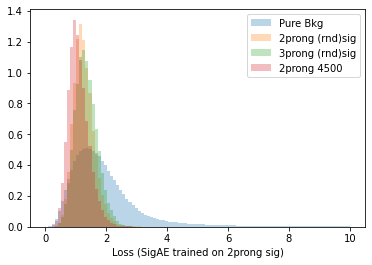

In [77]:
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='Pure Bkg');
#plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='3prong (rnd)sig');
plt.hist(loss_4500,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='2prong 4500');

#plt.yscale('log')
plt.xlabel('Loss (SigAE trained on 2prong sig)')
plt.legend(loc='upper right')
#plt.savefig('sigae_trained_on_2prongsig.png')

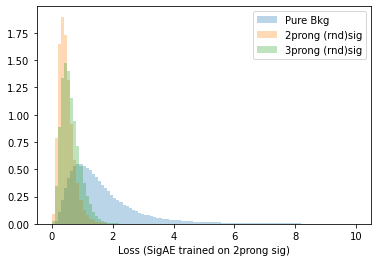

In [104]:
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='Pure Bkg');
#plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,10,100),density=True,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('Loss (SigAE trained on 2prong sig)')
plt.legend(loc='upper right')
#plt.savefig('sigae_trained_on_2prongsig.png')

In [47]:
len(loss_prong2)

55539

In [41]:
outputlist_waic

['../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb1.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb2.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb3.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_purebkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_rndbkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_2prong.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_3prong.npy']

In [42]:
outputlist_justloss

['../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb1.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb2.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb3.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_purebkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_rndbkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_2prong.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_3prong.npy']

In [34]:
sigae_bbloss

array([ 2832.3672,  8125.47  , 29922.496 , ...,  2359.0386,  2635.9333,
         640.2169], dtype=float32)

In [58]:
ae_def

{'type': 'sig',
 'trainon': '2prong',
 'features': 'cwola',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f8'}

In [141]:
sigae_bbloss

array([0.46685678, 1.5879018 , 0.58936137, ..., 0.59082854, 0.70994604,
       0.70424944], dtype=float32)

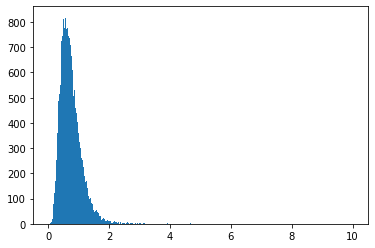

In [142]:
plt.hist(sigae_bbloss,bins=np.linspace(0,10,1001));

In [60]:
np.save('../data_strings/sigae_2prong_loss_bb3.npy',sigae_bbloss)

In [211]:
X_bkg = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
X_bkg = X_bkg[bkg_idx]

In [212]:
for i in range(12):
    X_bkg[:,i] = (X_bkg[:,i]-sig_mean[i])/sig_std[i]

In [161]:
total_bkg_test = torch.tensor(X_bkg)

In [162]:
sigae_bkgloss = torch.mean((sigmodel(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [163]:
sigae_sigloss = torch.mean((sigmodel(total_sig.float().cuda())[0]- total_sig.float().cuda())**2,dim=1).data.cpu().numpy()

In [176]:
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [309]:
f_bb1 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [310]:
dt_bb1 = f_bb1.values

In [311]:
X_bb1 = dt_bb1[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [312]:
X_bb1.shape

(1000000, 12)

In [313]:
sig_mean

[416.4436327724198,
 0.259460143970101,
 0.6475599434564594,
 0.7747571031756559,
 1.4414801240204307,
 232.28881387172063,
 115.19219609387073,
 0.4000458937255977,
 0.6497184345343743,
 0.7592483240780288,
 1.5724873295094448,
 139.77741938715204]

In [314]:
sig_std

[154.19379540115423,
 0.17056704944179107,
 0.14978212617036485,
 0.09894407762923978,
 0.4886539241053714,
 87.70941099970253,
 49.68849330603538,
 0.1622952691607605,
 0.14863130231138283,
 0.10503384225762816,
 0.6713928483438475,
 48.672440905600446]

In [315]:
for i in range(12):
    X_bb1[:,i] = (X_bb1[:,i]-sig_mean[i])/sig_std[i]

(array([246458., 189649., 134796.,  95188.,  64278.,  40409.,  20912.,
          9337.,   4219.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

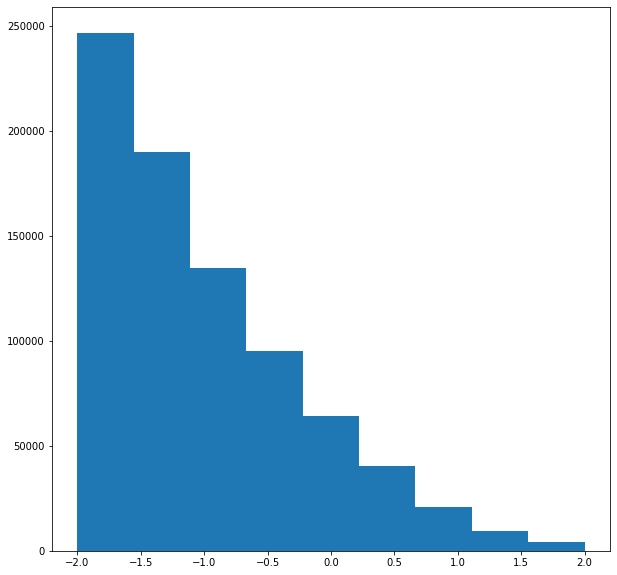

In [317]:
plt.hist(X_bb1[:,0],bins = np.linspace(-2,2,10))

In [318]:
(torch.tensor(dt[i * chunk_size:(i + 1) * chunk_size]) for i in range ) 

TypeError: 'type' object is not iterable

In [319]:
def get_loss(dt):
    
    chunk_size=5000 
    total_size=1000000
    i = 0
    i_max = total_size // chunk_size

    print(i_max)
    
    
    
    gen = (torch.tensor(dt[i*chunk_size: (i + 1) * chunk_size]) for i in range(i_max)) 

        
    with torch.no_grad():
        
        loss = [
            n
            for total_in_selection in gen
            for n in torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
        ]
        
    return loss

In [287]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [320]:
bb1_loss_sig = get_loss(X_bb1)

200


In [321]:
bb1_loss_sig = np.array(bb1_loss_sig,dtype=np.float)

In [322]:
print(bb1_loss_sig)

[1.90564466 0.96934295 1.35960376 ... 0.59359992 2.21692467 2.44283652]


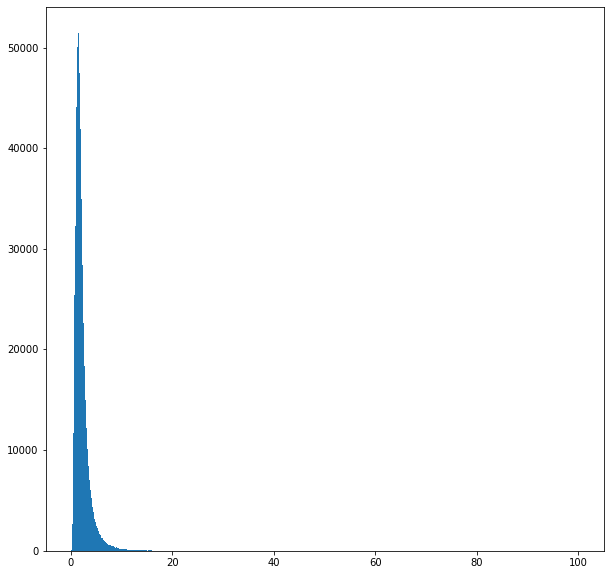

In [323]:
plt.hist(bb1_loss_sig,bins=np.linspace(0,100,1001));

In [324]:
np.save('../data_strings/sigaeloss_bb1.npy',bb1_loss_sig)

In [177]:
dt_3prong = f_3prong.values

In [178]:
Z = dt_3prong[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [179]:
Z.shape

(100000, 12)

In [180]:
for i in range(12):
    Z[:,i] = (Z[:,i]-sig_mean[i])/sig_std[i]

In [181]:
total_3prong = torch.tensor(Z)

In [199]:
bkgae_bkgloss = torch.mean((model(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [ ]:
bkgae_3prongloss = torch.mean((model(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [182]:
sigae_3prongloss = torch.mean((sigmodel(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [183]:
sigae_3prongloss.shape

(100000,)

Text(0.5, 0, 'Signal AE Loss')

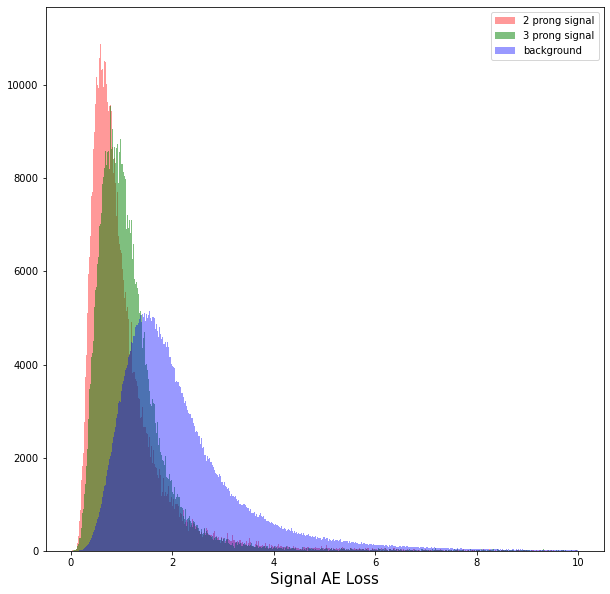

In [216]:
bins = np.linspace(0,10,1001)
plt.hist(sigae_sigloss,bins,weights = np.ones(len(signal_idx))*10,alpha=0.4,color='r',label='2 prong signal');
plt.hist(sigae_3prongloss,bins,weights = np.ones(100000)*10,alpha=0.5,color='g',label='3 prong signal');
plt.hist(sigae_bkgloss,bins,alpha=0.4,color='b',label='background');
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlabel('Signal AE Loss',fontsize=15)



In [193]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr      

In [194]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [196]:
tpr_2prong, fpr_2prong = get_tpr_fpr(sigae_sigloss,sigae_bkgloss,'sig')
tpr_3prong, fpr_3prong = get_tpr_fpr(sigae_3prongloss,sigae_bkgloss,'sig')

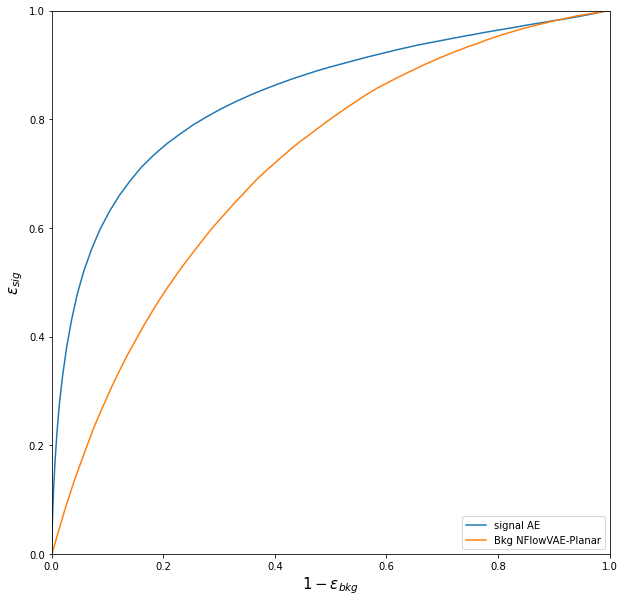

In [217]:
plt.plot(fpr_2prong,tpr_2prong,label='signal AE')
#plt.plot(VAE_bkg_fpr,VAE_bkg_tpr,label='Bkg VAE-Vanilla')
plt.plot(bkg_fpr4,bkg_tpr4,label='Bkg NFlowVAE-Planar')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Curve_sigae.png')

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)